In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.callbacks import EarlyStopping
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils

In [2]:
df = pd.read_csv('../input/devanagari-character-set/data.csv')

# From First Col to (last-1) col with all rows
X = df.iloc[:,:-1]

# last Col with all rows
y = df.iloc[:,-1]

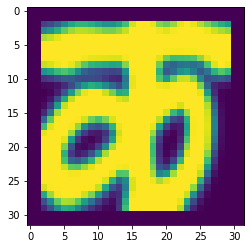

In [3]:
X_images = X.values.reshape(92000,32,32)
import matplotlib.pyplot as plt
plt.imshow(X_images[0])
plt.show()

In [4]:
# output in binary format for NN
from sklearn.preprocessing import LabelBinarizer
binencoder = LabelBinarizer()
y = binencoder.fit_transform(y)

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_images, y, test_size=0.20, random_state=92)
X_train = X_train/255
X_test = X_test/255

# changing from 3 to 4 dimensions of inputss
X_train = X_train.reshape(X_train.shape[0], 32, 32, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 32, 32, 1).astype('float32')

In [6]:
# Building the Convolutional Model
conv_model = Sequential()
conv_model.add(
    Conv2D(32, (4, 4), 
           input_shape=(32, 32,1),
           activation='relu', 
           name="firstConv"
    )
)

conv_model.add(
    MaxPooling2D(pool_size=(2, 2), 
                 name="FirstPool"
                )
)

conv_model.add(
    Conv2D(64, (3, 3), 
           activation='relu', 
           name="SecondConv"
          )
)

conv_model.add(
    MaxPooling2D(
        pool_size=(2, 2),
        name="SecondPool")
)
conv_model.add(Dropout(0.2)) # Prevents Overfitting in Conv Nete
conv_model.add(Flatten())

conv_model.add(
    Dense(128,
          activation='relu',
          name="dense_1"
         )
)
conv_model.add(
    Dense(50, 
          activation='relu', 
          name="dense_2"
         )
)

# Output Layer with 46 Unique Outputs
conv_model.add(
    Dense(46, 
          activation='softmax', 
          name="modeloutput"
         )
)
conv_model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
firstConv (Conv2D)           (None, 29, 29, 32)        544       
_________________________________________________________________
FirstPool (MaxPooling2D)     (None, 14, 14, 32)        0         
_________________________________________________________________
SecondConv (Conv2D)          (None, 12, 12, 64)        18496     
_________________________________________________________________
SecondPool (MaxPooling2D)    (None, 6, 6, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 6, 6, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2

In [7]:
conv_model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam',
    metrics=['accuracy']
)

In [8]:
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

                     
checkpoint = ModelCheckpoint("hindi_handwritting_detection.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0, 
                          patience = 3,
                          verbose = 1,
                          restore_best_weights = True)
callbacks = [earlystop, checkpoint]

result = conv_model.fit(X_train, y_train, validation_split=0.20, epochs=10, batch_size=92,verbose=2,callbacks = callbacks)

Epoch 1/10
640/640 - 9s - loss: 0.9176 - accuracy: 0.7455 - val_loss: 0.3139 - val_accuracy: 0.9067

Epoch 00001: val_loss improved from inf to 0.31395, saving model to hindi_handwritting_detection.h5
Epoch 2/10
640/640 - 2s - loss: 0.2643 - accuracy: 0.9203 - val_loss: 0.2079 - val_accuracy: 0.9396

Epoch 00002: val_loss improved from 0.31395 to 0.20791, saving model to hindi_handwritting_detection.h5
Epoch 3/10
640/640 - 2s - loss: 0.1661 - accuracy: 0.9497 - val_loss: 0.1594 - val_accuracy: 0.9527

Epoch 00003: val_loss improved from 0.20791 to 0.15944, saving model to hindi_handwritting_detection.h5
Epoch 4/10
640/640 - 2s - loss: 0.1215 - accuracy: 0.9620 - val_loss: 0.1428 - val_accuracy: 0.9588

Epoch 00004: val_loss improved from 0.15944 to 0.14281, saving model to hindi_handwritting_detection.h5
Epoch 5/10
640/640 - 2s - loss: 0.0922 - accuracy: 0.9708 - val_loss: 0.1255 - val_accuracy: 0.9646

Epoch 00005: val_loss improved from 0.14281 to 0.12554, saving model to hindi_handw

In [9]:
scores = conv_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))


Accuracy: 97.23%


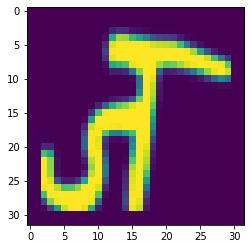

In [10]:
num = 15000
plt.imshow(X_images[num])
plt.show()


In [11]:
#how to predict
imgTrans = X_images[num].reshape(1,32,32,1)
imgTrans.shape

predictions = conv_model.predict(imgTrans)
binencoder.classes_[np.argmax(predictions)]

'character_08_ja'